Necessary Imports:

In [1]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from num2words import num2words
from collections import Counter
import csv
import tf_idf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import json
from tqdm import tqdm
import pandas as pd
from xml.etree import ElementTree

# Taking data from XML file 

In [2]:
dataset=[]
tree = ElementTree.parse('./test.xml')
root = tree.getroot()

for book in root.findall('book'):
    i=0
    for metadata in book.find('metadata'):
        if(i==0):
            x=metadata
        if(i==1):
            author=metadata.text
        if(i==2):
            published=metadata.text
        if(i==3):
            pagenum=metadata.text
        if(i==4):
            break
        i+=1   
    
    s=''    
    if(x.find('d1')!=None):
        s=x.find('d1').text
    else:
        s=x.find('d0').text
            
    
    dataset.append([book.find('title').text,s,book.find('body').text,author,published,pagenum])
    
    
tree = ElementTree.parse('./train.xml')
root = tree.getroot()

for book in root.findall('book'):
    i=0
    for metadata in book.find('metadata'):
        if(i==0):
            x=metadata
        if(i==1):
            author=metadata.text
        if(i==2):
            published=metadata.text
        if(i==3):
            pagenum=metadata.text
        if(i==4):
            break
        i+=1
        
    
    
    s=''    
    if(x.find('d1')!=None):
        s=x.find('d1').text
    else:
        s=x.find('d0').text
            
    
    dataset.append([book.find('title').text,s,book.find('body').text,author,published,pagenum])

In [3]:
df=pd.DataFrame(dataset,columns=['Name','Genres','Summary',
                                 'Author','Published','PageNum'])


In [4]:
df

,Name,Genres,Summary,Author,Published,PageNum
0,Teenage Mutant Ninja Turtles: The Box Set Volu...,Graphic Novels and Manga,TMNT co-creator Kevin Eastman and writer Tom W...,"Kevin Eastman, Tom Waltz","Dec 15, 2015",520 Pages
1,Betty and Veronica: Fairy Tales,Children’s Middle Grade Books,Take a magical trip down Storybook Lane with t...,Archie Superstars,"Dec 06, 2016",256 Pages
2,Friends and Fauxs,Women’s Fiction,"Tracie Howard is back with all of the Gucci, g...",Tracie Howard,"Jul 28, 2009",288 Pages
3,Anti-Education,Religion and Philosophy,"AN NYRB Classics OriginalIn 1869, at the age o...",Friedrich Nietzsche,"Dec 15, 2015",160 Pages
4,Fallout,Mystery and Suspense,A first-class letter–containing a single sheet...,Tetsuo Takashima,"Jan 29, 2013",288 Pages
5,Dark Diversions,Literary Fiction,"In Dark Diversions, acclaimed author John Rals...",John Ralston Saul,"Aug 13, 2013",336 Pages
6,The Future of the Image,Religion and Philosophy,"In The Future of the Image, Jacques Rancière d...",Jacques Ranciere,"Feb 02, 2009",147 Pages
7,Kripalu Yoga,Health and Fitness,"“Over an extraordinary thirty year history, Kr...","Richard Faulds, Senior Teaching Staff KCYH","Dec 27, 2005",432 Pages
8,The Mystery Woman,Romance,The second Ladies of Lantern Street novel from...,Amanda Quick,"Apr 01, 2014",400 Pages
9,Jasmine Is My Babysitter (Disney Princess),Children’s Books,An original Disney Princess Little Golden Book...,Apple Jordan,"Sep 05, 2017",24 Pages


# Genre Count

In [6]:
from io import StringIO

col = ['Genres', 'Summary']
df = df[col]
df = df[pd.notnull(df['Summary'])]
df.columns = ['Genres', 'Summary']
df['category_id'] = df['Genres'].factorize()[0]
#print(df['category_id'])
category_id_df = df[['Genres', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Genres']].values)
df.head()

,Genres,Summary,category_id
0,Graphic Novels and Manga,TMNT co-creator Kevin Eastman and writer Tom W...,0
1,Children’s Middle Grade Books,Take a magical trip down Storybook Lane with t...,1
2,Women’s Fiction,"Tracie Howard is back with all of the Gucci, g...",2
3,Religion and Philosophy,"AN NYRB Classics OriginalIn 1869, at the age o...",3
4,Mystery and Suspense,A first-class letter–containing a single sheet...,4


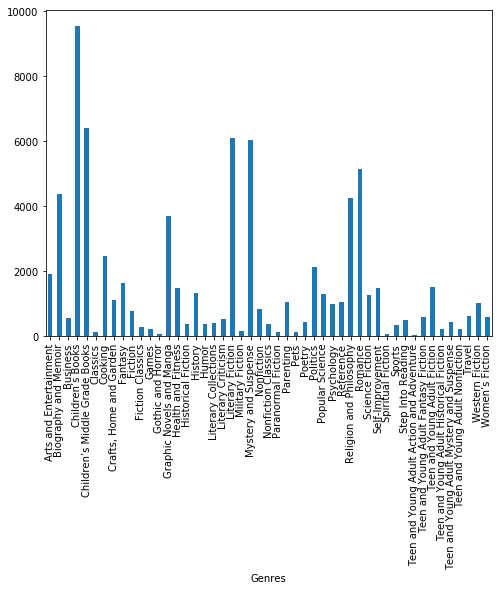

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Genres').Summary.count().plot.bar(ylim=0)
plt.show()


 # Number of features per Summary


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Summary)
labels = df.category_id
features.shape

(77109, 184635)

# Finding more correlated terms
takes more time

In [11]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# 'Arts and Entertainment':
  . Most correlated unigrams:
. watercolour
. artists
  . Most correlated bigrams:
. generously illustrated
. step demonstrations
# 'Biography and Memoir':
  . Most correlated unigrams:
. biography
. memoir
  . Most correlated bigrams:
. true story
. definitive biography
# 'Business':
  . Most correlated unigrams:
. management
. managers
  . Most correlated bigrams:
. project managers
. project management
# 'Children’s Books':
  . Most correlated unigrams:
. little
. board
  . Most correlated bigrams:
. board book
. picture book
# 'Children’s Middle Grade Books':
  . Most correlated unigrams:
. newbery
. libs
  . Most correlated bigrams:
. middle grade
. mad libs
# 'Classics':
  . Most correlated unigrams:
. poems
. sonnets
  . Most correlated bigrams:
. pocket poets
. library pocket
# 'Cooking':
  . Most correlated unigrams:
. cookbook
. recipes
  . Most correlated bigrams:
. gluten free
. weight loss
# 'Crafts, Home and Garden':
  . Most correlated unigram

KeyboardInterrupt: 

# Tfidf Vectorizer

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(df['Summary'], df['Genres'], random_state = 0)
count_vect = CountVectorizer()
#BagOfWords
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)



# Giving Summaries Manually and Checking


In [13]:
#Mystery And Suspense(Da Vinci Code)
print("Original:Mystery And Suspense:",end="")
print(clf.predict(count_vect.transform(["An ingenious code hidden in the works of Leonardo da Vinci.\
A desperate race through the cathedrals and castles of Europe.\
An astonishing truth concealed for centuries unveiled at last.\
While in Paris, Harvard symbologist Robert Langdon is awakened by a phone call in the dead of the night. The elderly curator of the Louvre has been murdered inside the museum, his body covered in baffling symbols. As Langdon and gifted French cryptologist Sophie Neveu sort through the bizarre riddles, they are stunned to discover a trail of clues hidden in the works of Leonardo da Vinci—clues visible for all to see and yet ingeniously disguised by the painter.\
Even more startling, the late curator was involved in the Priory of Sion—a secret society whose members included Sir Isaac Newton, Victor Hugo, and Da Vinci—and he guarded a breathtaking historical secret. Unless Langdon and Neveu can decipher the labyrinthine puzzle—while avoiding the faceless adversary who shadows their every move—the explosive, ancient truth will be lost forever."])))


#literary Fiction(The GoldFinch)
print("Original:Literary Fiction:",end="")
print(clf.predict(count_vect.transform(["WINNER OF THE PULITZER PRIZE. Theo Decker, a 13-year-old New Yorker, miraculously survives an accident that kills his mother. Abandoned by his father, Theo is taken in by the family of a wealthy friend. Bewildered by his strange new home on Park Avenue, disturbed by schoolmates who don’t know how to talk to him, and tormented above all by his longing for his mother, he clings to the one thing that reminds him of her: a small, mysteriously captivating painting that ultimately draws Theo into the underworld of art.\
As an adult, Theo moves silkily between the drawing rooms of the rich and the dusty labyrinth of an antiques store where he works. He is alienated and in love—and at the center of a narrowing, ever more dangerous circle.\
The Goldfinch is a mesmerizing, stay-up-all-night and tell-all-your-friends triumph, an old-fashioned story of loss and obsession, survival and self-invention, and the ruthless machinations of fate."])))

#Romance
print("Original:Romance",end="")
print(clf.predict(count_vect.transform(["As a successful social media journalist with half a million followers, seventeen-year-old Cal is used to sharing his life online. But when his pilot father is selected for a highly publicized NASA mission to Mars, Cal and his family relocate from Brooklyn to Houston and are thrust into a media circus.\
Amidst the chaos, Cal meets sensitive and mysterious Leon, another “Astrokid,” and finds himself falling head over heels—fast. As the frenzy around the mission grows, so does their connection. But when secrets about the program are uncovered, Cal must find a way to reveal the truth without hurting the people who have become most important to him.\
Expertly capturing the thrill of first love and the self-doubt all teens feel, debut author Phil Stamper is a new talent to watch"])))


#Biography and memoir(When time stopped)
print("Original:Biography",end="")
print(clf.predict(count_vect.transform(["In 1941, the first Neumann family member was taken by the Nazis, arrested in German-occupied Czechoslovakia for bathing in a stretch of river forbidden to Jews. He was transported to Auschwitz. Eighteen days later his prisoner number was entered into the morgue book.\
Of thirty-four Neumann family members, twenty-five were murdered by the Nazis. One of the survivors was Hans Neumann, who, to escape the German death net, traveled to Berlin and hid in plain sight under the Gestapo’s eyes. What Hans experienced was so unspeakable that, when he built an industrial empire in Venezuela, he couldn’t bring himself to talk about it. All his daughter Ariana knew was that something terrible had happened.\
When Hans died, he left Ariana a small box filled with letters, diary entries, and other memorabilia. Ten years later Ariana finally summoned the courage to have the letters translated, and she began reading. What she discovered launched her on a worldwide search that would deliver indelible portraits of a family loving, finding meaning, and trying to survive amid the worst that can be imagined.\
When Time Stopped is a detective story and an epic family memoir, spanning nearly ninety years and crossing oceans. Neumann brings each relative to vivid life. In uncovering her father’s story after all these years, she discovers nuance and depth to her own history and liberates poignant and thought-provoking truths about the threads of humanity that connect us all."])))

#Fantasy Fiction(The Tyrants tomb)
print("Original:Fantasy Fiction",end="")
print(clf.predict(count_vect.transform(["In his penultimate adventure, a devastated but determined Apollo travels to Camp Jupiter, where he must learn what it is to be a hero, or die trying.\
It is not easy being Apollo, especially when you have been turned into a human and banished from Olympus. On his path to restoring five ancient oracles and reclaiming his godly powers, Apollo (aka Lester Papadopoulos) has faced both triumphs and tragedies. Now his journey takes him to Camp Jupiter in the San Francisco Bay Area, where the Roman demigods are preparing for a desperate last stand against the evil Triumvirate of Roman emperors. Hazel, Reyna, Frank, Tyson, Ella, and many other old friends will need Apollo's aid to survive the onslaught. Unfortunately, the answer to their salvation lies in the forgotten tomb of a Roman ruler . . . someone even worse than the emperors Apollo has already faced"])))

#Children's Books(New Kid)
print("Original:Children's Books",end="")
print(clf.predict(count_vect.transform(["Seventh grader Jordan Banks loves nothing more than drawing cartoons about his life. But instead of sending him to the art school of his dreams, his parents enroll him in a prestigious private school known for its academics, where Jordan is one of the few kids of color in his entire grade.\
As he makes the daily trip from his Washington Heights apartment to the upscale Riverdale Academy Day School, Jordan soon finds himself torn between two worlds—and not really fitting into either one. Can Jordan learn to navigate his new school culture while keeping his neighborhood friends and staying true to himself"])))

#Travel Literature(The Lost Pianos of Siberia)
print("Original:Travel Literture",end="")
print(clf.predict(count_vect.transform(["Siberia’s story is traditionally one of exiles, penal colonies and unmarked graves. Yet there is another tale to tell.\
Dotted throughout this remote land are pianos – grand instruments created during the boom years of the nineteenth century, and humble, Soviet-made uprights that found their way into equally modest homes. They tell the story of how, ever since entering Russian culture under the influence of Catherine the Great, piano music has run through the country like blood.\
How these pianos travelled into this snow-bound wilderness in the first place is testament to noble acts of fortitude by governors, adventurers and exiles. That stately instruments might still exist in such a hostile landscape is remarkable. That they are still capable of making music in far-flung villages is nothing less than a miracle.\
But this is Siberia, where people can endure the worst of the world — and where music reveals a deep humanity in the last place on earth you would expect to find it"])))


#NonFiction(Hood Feminism)
print("Original:NonFiction",end="")
print(clf.predict(count_vect.transform(["Today's feminist movement has a glaring blind spot, and paradoxically, it is women. Mainstream feminists rarely talk about meeting basic needs as a feminist issue, argues Mikki Kendall, but food insecurity, access to quality education, safe neighborhoods, a living wage, and medical care are all feminist issues. All too often, however, the focus is not on basic survival for the many, but on increasing privilege for the few. That feminists refuse to prioritize these issues has only exacerbated the age-old problem of both internecine discord and women who rebuff at carrying the title. Moreover, prominent white feminists broadly suffer from their own myopia with regard to how things like race, class, sexual orientation, and ability intersect with gender. How can we stand in solidarity as a movement, Kendall asks, when there is the distinct likelihood that some women are oppressing others?\
In her searing collection of essays, Mikki Kendall takes aim at the legitimacy of the modern feminist movement arguing that it has chronically failed to address the needs of all but a few women. Drawing on her own experiences with hunger, violence, and hypersexualization, along with incisive commentary on politics, pop culture, the stigma of mental health, and more, Hood Feminism delivers an irrefutable indictment of a movement in flux. An unforgettable debut, Kendall has written a ferocious clarion call to all would-be feminists to live out the true mandate of the movement in thought and in deed."])))




Mystery And Suspense:['Mystery and Suspense']
Literary Fiction:['Literary Fiction']
Romance['Teen and Young Adult Fiction']
Biography['Biography and Memoir']
Fantasy Fiction['Children’s Middle Grade Books']
Children's Books['Biography and Memoir']
Travel Literture['Popular Science']
NonFiction['Biography and Memoir']


# Accuracy


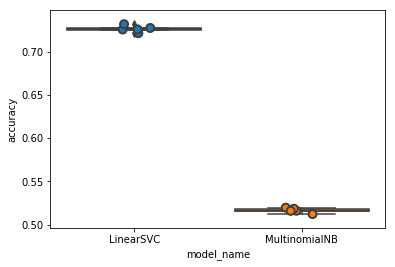

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    #DecisionTreeClassifier(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [15]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC        0.726478
MultinomialNB    0.516386
Name: accuracy, dtype: float64

In [28]:
from io import StringIO

col = ['Genres', 'Summary']
df = df[col]
df = df[pd.notnull(df['Summary'])]
df.columns = ['Genres', 'Summary']
df['category_id'] = df['Genres'].factorize()[0]
#print(df['category_id'])
category_id_df = df[['Genres', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Genres']].values)
df.head()

,Genres,Summary,category_id
0,Science Fiction,alex teenager living near future england lead...,0
1,Children's literature,ged young boy gont one larger islands north a...,1
2,Science Fiction,living mars deckard acting consultant movie c...,0
3,Science Fiction,beginning several months events blade runner ...,0
4,Science Fiction,nine years emperor paul muad dib walked deser...,0


# Clean Summaries

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = df
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
data['Summary'] = data['Summary'].str.lower()
data['Summary'] = data['Summary'].apply(cleanHtml)
data['Summary'] = data['Summary'].apply(cleanPunc)
data['Summary'] = data['Summary'].apply(keepAlpha)

# Remove Stopwords

In [10]:

stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['Summary'] = data['Summary'].apply(removeStopWords)


# Stemming

In [11]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['Summary'] = data['Summary'].apply(stemming)

In [14]:
df

,Genres,Summary,category_id
0,Graphic Novels and Manga,tmnt co creator kevin eastman writer tom waltz...,0
1,Children’s Middle Grade Books,take magic trip storybook lane collect best fa...,1
2,Women’s Fiction,traci howard back gucci glitz glamour steami f...,2
3,Religion and Philosophy,nyrb classic originalin age twenti precoci bri...,3
4,Mystery and Suspense,first class letter contain singl sheet paper d...,4
5,Literary Fiction,dark divers acclaim author john ralston saul s...,5
6,Religion and Philosophy,futur imag jacqu ranci develop fascin new conc...,3
7,Health and Fitness,extraordinari thirti year histori kripalu cent...,6
8,Romance,second ladi lantern street novel amanda quick ...,7
9,Children’s Books,origin disney princess littl golden book star ...,8


# TF-IDF

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(data['Summary'], data['Genres'], random_state = 0)
count_vect = CountVectorizer()
#BagOfWords
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)



In [26]:
#Mystery And Suspense(Da Vinci Code)
print("Mystery And Suspense:",end="")
print(clf.predict(count_vect.transform(["An ingenious code hidden in the works of Leonardo da Vinci.\
A desperate race through the cathedrals and castles of Europe.\
An astonishing truth concealed for centuries unveiled at last.\
While in Paris, Harvard symbologist Robert Langdon is awakened by a phone call in the dead of the night. The elderly curator of the Louvre has been murdered inside the museum, his body covered in baffling symbols. As Langdon and gifted French cryptologist Sophie Neveu sort through the bizarre riddles, they are stunned to discover a trail of clues hidden in the works of Leonardo da Vinci—clues visible for all to see and yet ingeniously disguised by the painter.\
Even more startling, the late curator was involved in the Priory of Sion—a secret society whose members included Sir Isaac Newton, Victor Hugo, and Da Vinci—and he guarded a breathtaking historical secret. Unless Langdon and Neveu can decipher the labyrinthine puzzle—while avoiding the faceless adversary who shadows their every move—the explosive, ancient truth will be lost forever."])))


#literary Fiction(The GoldFinch)
print("Literary Fiction:",end="")
print(clf.predict(count_vect.transform(["WINNER OF THE PULITZER PRIZE. Theo Decker, a 13-year-old New Yorker, miraculously survives an accident that kills his mother. Abandoned by his father, Theo is taken in by the family of a wealthy friend. Bewildered by his strange new home on Park Avenue, disturbed by schoolmates who don’t know how to talk to him, and tormented above all by his longing for his mother, he clings to the one thing that reminds him of her: a small, mysteriously captivating painting that ultimately draws Theo into the underworld of art.\
As an adult, Theo moves silkily between the drawing rooms of the rich and the dusty labyrinth of an antiques store where he works. He is alienated and in love—and at the center of a narrowing, ever more dangerous circle.\
The Goldfinch is a mesmerizing, stay-up-all-night and tell-all-your-friends triumph, an old-fashioned story of loss and obsession, survival and self-invention, and the ruthless machinations of fate."])))

#Romance
print("Romance",end="")
print(clf.predict(count_vect.transform(["As a successful social media journalist with half a million followers, seventeen-year-old Cal is used to sharing his life online. But when his pilot father is selected for a highly publicized NASA mission to Mars, Cal and his family relocate from Brooklyn to Houston and are thrust into a media circus.\
Amidst the chaos, Cal meets sensitive and mysterious Leon, another “Astrokid,” and finds himself falling head over heels—fast. As the frenzy around the mission grows, so does their connection. But when secrets about the program are uncovered, Cal must find a way to reveal the truth without hurting the people who have become most important to him.\
Expertly capturing the thrill of first love and the self-doubt all teens feel, debut author Phil Stamper is a new talent to watch"])))


#Biography and memoir(When time stopped)
print("Biography",end="")
print(clf.predict(count_vect.transform(["In 1941, the first Neumann family member was taken by the Nazis, arrested in German-occupied Czechoslovakia for bathing in a stretch of river forbidden to Jews. He was transported to Auschwitz. Eighteen days later his prisoner number was entered into the morgue book.\
Of thirty-four Neumann family members, twenty-five were murdered by the Nazis. One of the survivors was Hans Neumann, who, to escape the German death net, traveled to Berlin and hid in plain sight under the Gestapo’s eyes. What Hans experienced was so unspeakable that, when he built an industrial empire in Venezuela, he couldn’t bring himself to talk about it. All his daughter Ariana knew was that something terrible had happened.\
When Hans died, he left Ariana a small box filled with letters, diary entries, and other memorabilia. Ten years later Ariana finally summoned the courage to have the letters translated, and she began reading. What she discovered launched her on a worldwide search that would deliver indelible portraits of a family loving, finding meaning, and trying to survive amid the worst that can be imagined.\
When Time Stopped is a detective story and an epic family memoir, spanning nearly ninety years and crossing oceans. Neumann brings each relative to vivid life. In uncovering her father’s story after all these years, she discovers nuance and depth to her own history and liberates poignant and thought-provoking truths about the threads of humanity that connect us all."])))

#Fantasy Fiction(The Tyrants tomb)
print("Fantasy Fiction",end="")
print(clf.predict(count_vect.transform(["In his penultimate adventure, a devastated but determined Apollo travels to Camp Jupiter, where he must learn what it is to be a hero, or die trying.\
It is not easy being Apollo, especially when you have been turned into a human and banished from Olympus. On his path to restoring five ancient oracles and reclaiming his godly powers, Apollo (aka Lester Papadopoulos) has faced both triumphs and tragedies. Now his journey takes him to Camp Jupiter in the San Francisco Bay Area, where the Roman demigods are preparing for a desperate last stand against the evil Triumvirate of Roman emperors. Hazel, Reyna, Frank, Tyson, Ella, and many other old friends will need Apollo's aid to survive the onslaught. Unfortunately, the answer to their salvation lies in the forgotten tomb of a Roman ruler . . . someone even worse than the emperors Apollo has already faced"])))

#Children's Books(New Kid)
print("Children's Books",end="")
print(clf.predict(count_vect.transform(["Seventh grader Jordan Banks loves nothing more than drawing cartoons about his life. But instead of sending him to the art school of his dreams, his parents enroll him in a prestigious private school known for its academics, where Jordan is one of the few kids of color in his entire grade.\
As he makes the daily trip from his Washington Heights apartment to the upscale Riverdale Academy Day School, Jordan soon finds himself torn between two worlds—and not really fitting into either one. Can Jordan learn to navigate his new school culture while keeping his neighborhood friends and staying true to himself"])))

#Travel Literature(The Lost Pianos of Siberia)
print("Travel Literture",end="")
print(clf.predict(count_vect.transform(["Siberia’s story is traditionally one of exiles, penal colonies and unmarked graves. Yet there is another tale to tell.\
Dotted throughout this remote land are pianos – grand instruments created during the boom years of the nineteenth century, and humble, Soviet-made uprights that found their way into equally modest homes. They tell the story of how, ever since entering Russian culture under the influence of Catherine the Great, piano music has run through the country like blood.\
How these pianos travelled into this snow-bound wilderness in the first place is testament to noble acts of fortitude by governors, adventurers and exiles. That stately instruments might still exist in such a hostile landscape is remarkable. That they are still capable of making music in far-flung villages is nothing less than a miracle.\
But this is Siberia, where people can endure the worst of the world — and where music reveals a deep humanity in the last place on earth you would expect to find it"])))


#NonFiction(Hood Feminism)
print("NonFiction",end="")
print(clf.predict(count_vect.transform(["Today's feminist movement has a glaring blind spot, and paradoxically, it is women. Mainstream feminists rarely talk about meeting basic needs as a feminist issue, argues Mikki Kendall, but food insecurity, access to quality education, safe neighborhoods, a living wage, and medical care are all feminist issues. All too often, however, the focus is not on basic survival for the many, but on increasing privilege for the few. That feminists refuse to prioritize these issues has only exacerbated the age-old problem of both internecine discord and women who rebuff at carrying the title. Moreover, prominent white feminists broadly suffer from their own myopia with regard to how things like race, class, sexual orientation, and ability intersect with gender. How can we stand in solidarity as a movement, Kendall asks, when there is the distinct likelihood that some women are oppressing others?\
In her searing collection of essays, Mikki Kendall takes aim at the legitimacy of the modern feminist movement arguing that it has chronically failed to address the needs of all but a few women. Drawing on her own experiences with hunger, violence, and hypersexualization, along with incisive commentary on politics, pop culture, the stigma of mental health, and more, Hood Feminism delivers an irrefutable indictment of a movement in flux. An unforgettable debut, Kendall has written a ferocious clarion call to all would-be feminists to live out the true mandate of the movement in thought and in deed."])))




Mystery And Suspense:['Literary Fiction']
Literary Fiction:['Literary Fiction']
Romance['Teen and Young Adult Fiction']
Biography['Biography and Memoir']
Fantasy Fiction['Fantasy']
Children's Books['Children’s Middle Grade Books']
Travel Literture['Biography and Memoir']
NonFiction['Biography and Memoir']


In [29]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(data['Summary'])
# labels = data['category_id']

# Finding Accuracy After cleaning Data

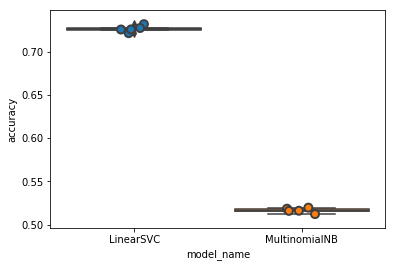

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    #DecisionTreeClassifier(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [16]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC        0.726478
MultinomialNB    0.516386
Name: accuracy, dtype: float64

# Multiple Features

In [33]:
df1=pd.DataFrame(dataset,columns=['Name','Genres','Summary','Author','Published','PageNum'])

In [35]:
df1['Summary']=data["Summary"]

In [37]:
Y= df1.drop(labels = ['Name','Summary','Author','Published','PageNum'], axis=1)
X= df1.drop(labels = ['Genres'], axis=1)


# Converting to dictionary  

In [38]:
t=[]
for i in range(len(X)):
    d={}
    d['Name']=X.Name[i]
    d['Summary']=X.Summary[i]
    d['Author']=X.Author[i]
    #d['Published']=X.Published[i]
    #d['PageNum']=X.PageNum[i]
    q=(d,Y.Genres[i])
    t.append(q)
#print(t[0])


In [39]:
n=int(len(X)/3)
test_set_feat = t[n:]
train_set_feat= t[:(2*n)]

classifier = nltk.NaiveBayesClassifier.train(train_set_feat)

print(nltk.classify.accuracy(classifier, test_set_feat))
print(type(test_set_feat[0]))

0.7204800995992686
<class 'tuple'>


In [40]:
d={}
d['Summary']="In 1941, the first Neumann family member was taken by the Nazis, arrested in German-occupied Czechoslovakia for bathing in a stretch of river forbidden to Jews. He was transported to Auschwitz. Eighteen days later his prisoner number was entered into the morgue book.\
Of thirty-four Neumann family members, twenty-five were murdered by the Nazis. One of the survivors was Hans Neumann, who, to escape the German death net, traveled to Berlin and hid in plain sight under the Gestapo’s eyes. What Hans experienced was so unspeakable that, when he built an industrial empire in Venezuela, he couldn’t bring himself to talk about it. All his daughter Ariana knew was that something terrible had happened.\
When Hans died, he left Ariana a small box filled with letters, diary entries, and other memorabilia. Ten years later Ariana finally summoned the courage to have the letters translated, and she began reading. What she discovered launched her on a worldwide search that would deliver indelible portraits of a family loving, finding meaning, and trying to survive amid the worst that can be imagined.\
When Time Stopped is a detective story and an epic family memoir, spanning nearly ninety years and crossing oceans. Neumann brings each relative to vivid life. In uncovering her father’s story after all these years, she discovers nuance and depth to her own history and liberates poignant and thought-provoking truths about the threads of humanity that connect us all."
d['Name']="When Time Stopped"
d['Author']="Ariana Neumann"

print(classifier.classify(d))

Children’s Books


In [41]:
classifier = nltk.classify.DecisionTreeClassifier.train(train_set_feat)
print(nltk.classify.accuracy(classifier, test_set_feat))
    

0.521203750534957


# For MultiLabel Classification

In [17]:
dataset=[]
tree = ElementTree.parse('./test.xml')
root = tree.getroot()

for book in root.findall('book'):
    for metadata in book.find('metadata'):
        #print(metadata)
        x=metadata
        break
    
    a=[]
    if(x.find('d3')!=None):  
        a.append(x.find('d3').text)
    if(x.find('d2')!=None):
        a.append(x.find('d2').text)
    if(x.find('d1')!=None):
        a.append(x.find('d1').text)
    if(x.find('d0')!=None):
        a.append(x.find('d0').text)
    
    dataset.append([book.find('title').text,a,book.find('body').text])

In [18]:

tree = ElementTree.parse('./train.xml')
root = tree.getroot()

for book in root.findall('book'):
    for metadata in book.find('metadata'):
        #print(metadata)
        x=metadata
        break
    
    a=[]
    if(x.find('d3')!=None):  
        a.append(x.find('d3').text)
    if(x.find('d2')!=None):
        a.append(x.find('d2').text)
    if(x.find('d1')!=None):
        a.append(x.find('d1').text)
    if(x.find('d0')!=None):
        a.append(x.find('d0').text)
    
    dataset.append([book.find('title').text,a,book.find('body').text])

In [19]:
df0=pd.DataFrame(dataset,columns=['Name','Genres','Summary'])

In [22]:
df0.Summary=df.Summary

# For Converting the dataframe for fitting into binary format

In [23]:
sGenres=set()
for i in range(len(df0)):
    for j in range(len(df0.Genres[i])):
        sGenres.add(df0.Genres[i][j])

gen={i:0 for i in sGenres}        
for i in range(len(df0)):
    for j in range(len(df0.Genres[i])):
        gen[df0.Genres[i][j]]+=1


# Finding total summaries for each genre

In [24]:
d={k: v for k, v in sorted(gen.items(), key=lambda item: item[1])}
l=len(d)
d={x:d[x] for x in list(reversed(list(d)))}
print(sum(d.values()))
for key,value in d.items():
    print(key,":",value)

182497
Nonfiction : 27109
Fiction : 25547
Children’s Books : 16396
Children’s Middle Grade Books : 6416
Literary Fiction : 6101
Mystery and Suspense : 6028
Romance : 5140
Biography and Memoir : 4390
Religion and Philosophy : 4245
Religion : 3711
Graphic Novels and Manga : 3694
Classics : 3249
Teen and Young Adult : 3127
Cooking : 2468
Suspense and Thriller : 2355
Personal Growth : 2322
Politics : 2146
Arts and Entertainment : 1927
Contemporary Romance : 1725
Crime Mysteries : 1715
Fantasy : 1647
Philosophy : 1580
Science : 1579
Teen and Young Adult Fiction : 1506
Self-Improvement : 1488
Health and Fitness : 1485
History : 1337
World History : 1312
Popular Science : 1302
Science Fiction : 1272
Humor : 1184
Crafts, Home and Garden : 1128
Cooking Methods : 1101
Art : 1095
Reference : 1072
Parenting : 1072
Cozy Mysteries : 1057
Historical Romance : 1040
Western Fiction : 1034
Psychology : 1008
Children’s Middle Grade Action and Adventure Books : 1003
Epic Fantasy : 924
Paranormal Romance :

In [25]:
x=0
l=[]

for i in d.keys():
    l.append(i)
    x+=1
print(len(l))

139


In [13]:
# import scipy
# for i in range(len(y)):
#     df['Genres'][i]=scipy.sparse.csr_matrix(y[i])
    
    

# Convertion

In [26]:
#name,Summary,Literary,Fantasy,Historical,Science,Fiction,NonFiction,Children,Suspense,Romance,Philosophy,games/sports,Music,
#print(df.Genres)
dataset1=[[0 for i in range(len(l)+2)]for j in range(len(df0))]
        
for i in range(len(df0)):
    a=[0 for i in range(len(l)+2)]
    for j in range(len(df0.Genres[i])):
        if df0.Genres[i][j] in l:
            a[l.index(df0.Genres[i][j])+2]=1
    for j in range(len(l)+2):
        if(j==0):
            dataset1[i][j]=df0.Name[i]
            
        elif(j==1):
            dataset1[i][j]=df0.Summary[i]
            
        else:
            dataset1[i][j]=a[j]
x=[]            
for i in range(len(l)+2):
    if(i==0):
        x.append('Name')
    elif(i==1):
        x.append('Summary')
    else:
        x.append(l[i-2])
df1=pd.DataFrame(dataset1,columns=x)


In [10]:
df1

,Name,Summary,Nonfiction,Fiction,Children’s Books,Children’s Middle Grade Books,Literary Fiction,Mystery and Suspense,Romance,Biography and Memoir,...,Weddings,Beauty,Travel: Asia,Native American History,World War I Military History,Travel: Caribbean and Mexico,Travel: Central and South America,Travel: Africa,Travel: Middle East,Travel: Australia and Oceania
0,The New York Times Daily Crossword Puzzles: Th...,Monday’s Crosswords Do with EaseTuesday’s Cros...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Creatures of the Night (Second Edition),Two of literary comics modern masters present ...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cornelia and the Audacious Escapades of the So...,Eleven-year-old Cornelia is the daughter of tw...,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Alchemist's Daughter,"During the English Age of Reason, a woman cloi...",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dangerous Boy,A modern-day retelling of The Strange Case of ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Mystery Mother (Replica #8),"Amy knows Nancy isn’t her birth mother, but sh...",0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,The Woman Who Wouldn't Die,The long-awaited follow-up to 2011’s Slash and...,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,The EC Archives: Two-Fisted Tales Volume 3,Before Two-Fisted Tales burst onto the scene i...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,The Complete Idiot's Guide to Intermediate Spa...,This revised edition offers expanded coverage ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Comic Sans Murder,"Clare Henry’s snowy Star City, Utah, oasis tur...",0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_Genre = df1.drop(['Name','Summary'], axis=1)
counts = []
categories = list(df_Genre.columns.values)
for i in categories:
    counts.append((i, df_Genre[i].sum()))
df_stats = pd.DataFrame(counts, columns=['Genre', 'number_of_blurbs'])
df_stats


,Genre,number_of_blurbs
0,Nonfiction,27109
1,Fiction,25547
2,Children’s Books,16396
3,Children’s Middle Grade Books,6416
4,Literary Fiction,6101
5,Mystery and Suspense,6028
6,Romance,5140
7,Biography and Memoir,4390
8,Religion and Philosophy,4245
9,Religion,3711


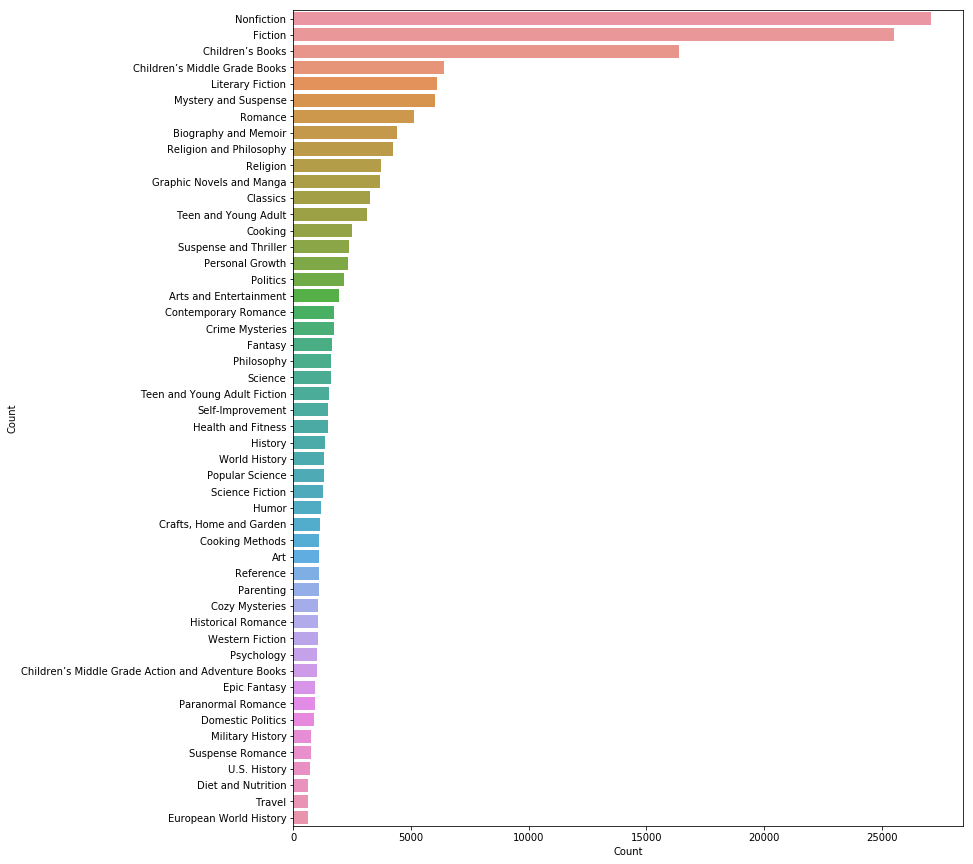

In [28]:
all_genres=sum(df0["Genres"],[])
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [29]:
df_Genre.columns.values

array(['Nonfiction', 'Fiction', 'Children’s Books',
       'Children’s Middle Grade Books', 'Literary Fiction',
       'Mystery and Suspense', 'Romance', 'Biography and Memoir',
       'Religion and Philosophy', 'Religion', 'Graphic Novels and Manga',
       'Classics', 'Teen and Young Adult', 'Cooking',
       'Suspense and Thriller', 'Personal Growth', 'Politics',
       'Arts and Entertainment', 'Contemporary Romance',
       'Crime Mysteries', 'Fantasy', 'Philosophy', 'Science',
       'Teen and Young Adult Fiction', 'Self-Improvement',
       'Health and Fitness', 'History', 'World History',
       'Popular Science', 'Science Fiction', 'Humor',
       'Crafts, Home and Garden', 'Cooking Methods', 'Art', 'Reference',
       'Parenting', 'Cozy Mysteries', 'Historical Romance',
       'Western Fiction', 'Psychology',
       'Children’s Middle Grade Action and Adventure Books',
       'Epic Fantasy', 'Paranormal Romance', 'Domestic Politics',
       'Military History', 'Suspense Roman

Text(0.5, 0, '# of Genres')

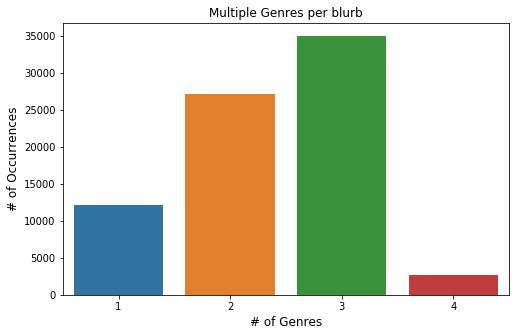

In [30]:
rowsums = df1.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple Genres per blurb")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Genres', fontsize=12)


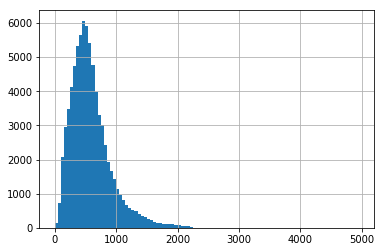

In [31]:
lens = df1.Summary.str.len()
lens.hist(bins = np.arange(0,5000,50))
 

In [32]:
train, test = train_test_split(df1, random_state=42, test_size=0.33, shuffle=True)
X_train = train.Summary
X_test = test.Summary
print(X_train.shape)
print(X_test.shape)

(51663,)
(25446,)


# TF-IDF

In [37]:
from sklearn.model_selection import train_test_split
data=df1#if not removing stopwords
train, test = train_test_split(data, random_state=42, test_size=0.1, shuffle=True)
train_text=train.Summary
test_text=test.Summary
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

x_train = vectorizer.transform(train_text)

y_train = train.drop(labels = ['Summary','Name'], axis=1)

x_test = vectorizer.transform(test_text)

y_test =test.drop(labels = ['Summary','Name'], axis=1)

# Finding Accuracy

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer
#from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score
import math




multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df0['Genres'])

# transform target variable
y = multilabel_binarizer.transform(df0['Genres'])

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(df0['Summary'], y, test_size=0.2, random_state=9)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

lr = LogisticRegression(max_iter=math.inf)
clf = OneVsRestClassifier(lr)
clf.fit(xtrain_tfidf, ytrain)

y_pred = clf.predict(xval_tfidf)
f1_score(yval, y_pred, average="micro")
y_pred_prob = clf.predict_proba(xval_tfidf)
t = 0.2505 # threshold value 0.2505 -> 0.7110468896756014
y_pred_new = (y_pred_prob >= t).astype(int)
f1_score(yval, y_pred_new, average="micro")



0.713629139641768

In [39]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower() 
    return text


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)





def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred_prob = clf.predict_proba(q_vec)
    t = 0.2505 # threshold value 0.2505 -> 0.7110468896756014
    q_pred_new = (q_pred_prob >= t).astype(int)

    return multilabel_binarizer.inverse_transform(q_pred_new)

for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Book: ", df0['Name'][k], "\nPredicted  genre: ", infer_tags(xval[k])), print("Actual genre: ",df0['Genres'][k], "\n")

    

Book:  Stewie and Brian's Family Guy Mad Libs 
Predicted  genre:  [('Children’s Books', 'Children’s Middle Grade Books')]
Actual genre:  ['Children’s Middle Grade Books', 'Children’s Books'] 

Book:  Dangerous Games 
Predicted  genre:  [('Fiction', 'Mystery and Suspense', 'Romance')]
Actual genre:  ['Contemporary Romance', 'Romance', 'Fiction'] 

Book:  A Street Girl Named Desire 
Predicted  genre:  [('Fiction', 'Romance')]
Actual genre:  ['Literary Fiction', 'Fiction'] 

Book:  Hegel's Lectures on History of Philosophy 
Predicted  genre:  [('Nonfiction', 'Philosophy', 'Religion and Philosophy')]
Actual genre:  ['Philosophy', 'Religion and Philosophy', 'Nonfiction'] 

Book:  Ooh-la-la (Max in Love) 
Predicted  genre:  [('Children’s Books',)]
Actual genre:  ['Children’s Books'] 



# OneVsRest Classification
linear Svc

In [40]:
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(train_text, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(test_text)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


... Processing Nonfiction
Test accuracy is 0.9399559071456361
... Processing Fiction
Test accuracy is 0.9297108027493192
... Processing Children’s Books
Test accuracy is 0.9569446245623136
... Processing Children’s Middle Grade Books
Test accuracy is 0.946958889897549
... Processing Literary Fiction
Test accuracy is 0.9425496044611594
... Processing Mystery and Suspense
Test accuracy is 0.9712099597976916
... Processing Romance
Test accuracy is 0.9744520814420957
... Processing Biography and Memoir
Test accuracy is 0.9561665153676566
... Processing Religion and Philosophy
Test accuracy is 0.9728958630527818
... Processing Religion
Test accuracy is 0.9813253793282324
... Processing Graphic Novels and Manga
Test accuracy is 0.9854752950330696
... Processing Classics
Test accuracy is 0.9788613668784852
... Processing Teen and Young Adult
Test accuracy is 0.9701724808714823
... Processing Cooking
Test accuracy is 0.9948126053689534
... Processing Suspense and Thriller
Test accuracy is 0.97

Test accuracy is 0.9989625210737907
... Processing Spiritual Fiction
Test accuracy is 0.9992218908053431
... Processing Military Science Fiction
Test accuracy is 0.9989625210737907
... Processing North American World History
Test accuracy is 0.9985734664764622
... Processing Latin American World History
Test accuracy is 0.9992218908053431
... Processing Western Romance
Test accuracy is 0.9994812605368953
... Processing Wine and Beverage
Test accuracy is 0.9993515756711192
... Processing Children’s Middle Grade Fantasy and Magical Books
Test accuracy is 0.9993515756711192
... Processing African World History
Test accuracy is 0.9996109454026715
... Processing Teen and Young Adult Action and Adventure
Test accuracy is 0.9994812605368953
... Processing Cyber Punk
Test accuracy is 0.9994812605368953
... Processing Erotica
Test accuracy is 0.9994812605368953
... Processing Weddings
Test accuracy is 0.9996109454026715
... Processing Beauty
Test accuracy is 0.9998703151342239
... Processing Tr